Script for training, testing, and re-training the models from different data sources.
Goal is to compare effacacy of outputs.

Important data structures:
- sim_membranes, test_membranes, new_sim_membranes - ordered lists (matching order of associated test/sim data) of membrane parameters. 'test_membranes' is (3,), others are (4,)
- test_data, sim_data, new_sim_data - pd dataframes containing all parameter & sim/test data
- all_data - tuples with all test data in a MLP-ready format ((us, ys), fs, ws)
- sk_data  - tuple with all test data in a SK-Learn friendly format


In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "5"
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

In [2]:
import jax
import jax.numpy as jnp
from jax import random, vmap, jit, grad, value_and_grad

from diffrax import diffeqsolve, ODETerm, SaveAt, Tsit5

import matplotlib.pyplot as plt

import optax
import torch.utils.data as data
from flax import linen as nn

import math

import pyDOE

from functools import partial
import itertools
from tqdm.auto import trange
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

import imageio

from sklearn import linear_model
from sklearn import svm
from sklearn.preprocessing import PolynomialFeatures, SplineTransformer, StandardScaler
from sklearn.pipeline import make_pipeline

from typing import (Any, Callable, Iterable, List, Optional, Sequence, Tuple,
                    Union)

import pandas as pd
import pickle

from archs import RPNEnsemble, RingEncoding, MonotonicActuator, identity, MLP, Actuator
from train_utils import  Operator, BatchedDataset

In [4]:
#### Preparing data
model_traindata = 'model_data_dictionary_N_Pa.pkl'
data_dict = pickle.load(open(model_traindata, 'rb'))


# describing dataset
num_membranes = len(data_dict)
print(f"In total there are {num_membranes} distinct membranes.")

def join_datasets(ds):
    # unpack quantities
    us = [d[0][0] for d in ds]
    ys = [d[0][1] for d in ds]
    fs = [d[1] for d in ds]
    ws = [d[2] for d in ds]
    
    # join quantities of interest
    us = jnp.concatenate(us)
    ys = jnp.concatenate(ys)
    fs = jnp.concatenate(fs)
    ws = jnp.concatenate(ws)

    return (us, ys), fs, ws

all_data = join_datasets(data_dict.values())

(us, ys), fs, ws = all_data

print("After grouping all data together, relevant shapes are:")
print(f"us : {us.shape}")
print(f"ys : {ys.shape}")
print(f"fs : {fs.shape}")
print(f"ws : {ws.shape}")

In total there are 22 distinct membranes.
After grouping all data together, relevant shapes are:
us : (188261, 7)
ys : (188261, 1)
fs : (188261, 1)
ws : (188261, 1)


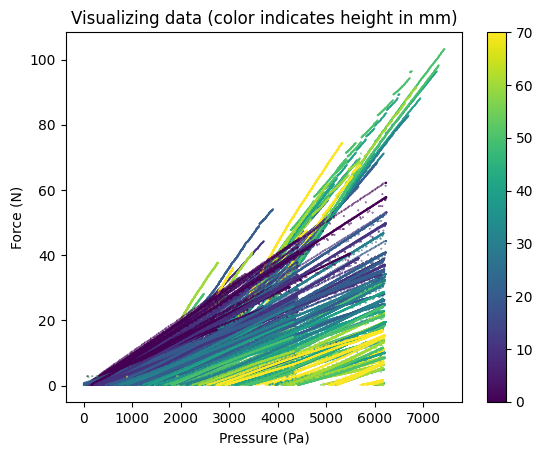

In [5]:
# visualize data
hs = us[:,0]
plt.scatter(ys, fs, c=hs, s=0.1)
plt.xlabel('Pressure (Pa)')
plt.ylabel('Force (N)')
plt.colorbar()
plt.title("Visualizing data (color indicates height in mm)")
plt.show()

In [6]:
model_data_grouped = data_dict

In [7]:
# read membrane names
membranes = []
for key in model_data_grouped.keys():
    # split the key by comma, drop spaces and brackets
    key_split = key.split(',')
    key_split = [x.replace('[','').replace(']','').replace(' ','') for x in key_split]
    key_split = [float(x) for x in key_split]   
    membranes.append(key_split)

In [8]:
# split out non-ringed values (for curve-fit baseline)
grouped_nr = {}
nr_membranes = []
for mem in membranes:
    # print(mem, len(model_data_grouped[str(mem)]))
    if jnp.isnan(mem[3]):
        grouped_nr[str(mem)] = model_data_grouped[str(mem)]
        nr_membranes.append(mem)
print(f'There is consistent data from {len(membranes)} membranes')
print(f'Of these, {len(grouped_nr.keys())} are no_ring membranes')

There is consistent data from 22 membranes
Of these, 6 are no_ring membranes


In [9]:
# concatenate ringed data
all_data = []
sk_ring_data = []
for key in membranes:
    check = key
    key = str(key)
    all_data.append(model_data_grouped[key])
    u = [x for x in model_data_grouped[key][0][0]]
    pressure = [x for x in model_data_grouped[key][0][1]]
    force = [x for x in model_data_grouped[key][1]]
    weights = [x for x in model_data_grouped[key][2]]
    if not jnp.isnan(jnp.array(check)).any():
        sk_ring_data.append(((jnp.hstack((jnp.array(u),jnp.array(pressure)))),jnp.array(force),jnp.array(weights)))


In [10]:
# concatenate non-ringed data
all_nr_data = []
sk_nr_data = []
scalers_nr = []
for key in nr_membranes:
    key = str(key)
    all_nr_data.append(grouped_nr[key])
    u = [x[:3] for x in grouped_nr[key][0][0]]
    pressure = [x for x in grouped_nr[key][0][1]]
    force = [x for x in grouped_nr[key][1]]
    weights = [x for x in grouped_nr[key][2]]
    sk = (((jnp.hstack((jnp.array(u),jnp.array(pressure)))),jnp.array(force),jnp.array(weights)))
    sk_nr_data.append(sk)


In [11]:
# check lengths of datasets
print(f'Test data: {len(all_data)}')
print(f'SK data (ring): {len(sk_ring_data)}')
print(f'Test data (no ring): {len(all_nr_data)}')
print(f'SK data (no ring): {len(sk_nr_data)}')


Test data: 22
SK data (ring): 16
Test data (no ring): 6
SK data (no ring): 6


In [12]:
# preprocess (normalize) SK data (scale each val to 0-1)
ring_max = jnp.zeros(len(sk_ring_data[0][0][0]))
nr_max = jnp.zeros(len(sk_nr_data[0][0][0]))
ring_min = jnp.zeros(len(sk_ring_data[0][0][0]))
nr_min = jnp.zeros(len(sk_nr_data[0][0][0]))

for i in range(len(sk_ring_data)):
    this_max = jnp.max(sk_ring_data[i][0], axis = 0)
    ring_max = jnp.max(jnp.vstack([this_max, ring_max]), axis = 0)
    this_min = jnp.min(sk_ring_data[i][0], axis = 0)
    ring_min = jnp.min(jnp.vstack([this_min, ring_min]), axis = 0)

for i in range(len(sk_nr_data)):
    this_max = jnp.max(sk_nr_data[i][0], axis = 0)
    nr_max = jnp.max(jnp.vstack([this_max, nr_max]), axis = 0)
    this_min = jnp.min(sk_nr_data[i][0], axis = 0)
    nr_min = jnp.min(jnp.vstack([this_min, nr_min]), axis = 0)    

for j in range(len(ring_max)):
    us = sk_ring_data[0][0]

# Normalize input data column-wise
normalized_sk_ring_data = tuple([[(data[0] - ring_min) / (ring_max - ring_min) for data in sk_ring_data], [data[1] for data in sk_ring_data], [data[2] for data in sk_ring_data]])

normalized_sk_nr_data = tuple(
    [ [(data[0] - nr_min) / (nr_max - nr_min) for data in sk_nr_data] , [data[1] for data in sk_nr_data], [data[2] for data in sk_nr_data] ]
)

## K-Fold Cross Validation

### Function Definition

In [13]:
# selecting training data
def train_data(k_groups, test_k, all_nr_data):
    train_us = []
    train_ys = []
    train_fs = []
    train_ws = []

    for i in jnp.arange(len(k_groups)):
        if i == test_k:
            continue
        group = [all_nr_data[i] for i in k_groups[i]]
        train_us = train_us + [d[0][0] for d in group] # include data from this group
        train_ys = train_ys + [d[0][1] for d in group] # include data from this group
        train_fs = train_fs + [d[1] for d in group] # include data from this group
        train_ws = train_ws + [d[2] for d in group] # include data from this group
    # now concatenate everything into a single array
    train_us = jnp.concatenate(train_us)
    train_ys = jnp.concatenate(train_ys)
    train_fs = jnp.concatenate(train_fs)
    train_ws = jnp.concatenate(train_ws)


    train_data = (train_us, train_ys), train_fs, train_ws
    return train_data

In [14]:
def train_all_data(test_group_mems, all_data):
    all_train_us = []
    all_train_ys = []
    all_train_fs = []
    all_train_ws = []

    check_mems = [str(x) for x in test_group_mems]
    for i in range(len(all_data)):
        if str(membranes[i]) in check_mems:
            continue
        group = all_data[i]
        all_train_us.append(group[0][0])
        all_train_ys.append(group[0][1])
        all_train_fs.append(group[1])
        all_train_ws.append(group[2])

    # now concatenate everything into a single array
    all_train_us = jnp.concatenate(all_train_us)
    all_train_ys = jnp.concatenate(all_train_ys)
    all_train_fs = jnp.concatenate(all_train_fs)
    all_train_ws = jnp.concatenate(all_train_ws)

    all_train_data = (all_train_us, all_train_ys), all_train_fs, all_train_ws
    return all_train_data

In [15]:
# Define model paramenters (match best from hyperparameter search)
def init_model(train_data, data_loader):

    # define architecture
    ensemble_size = 32
    ring_encoder = RingEncoding(24, identity)
    latent_encoder = MLP([16,16,16,16], activation=nn.gelu)
    arch = MonotonicActuator(
    # arch = Actuator(
        ring_encoder,
        latent_encoder,
        polynomial_degree=1,
        output_activation=nn.leaky_relu,
    )
    ensemble = RPNEnsemble(arch, ensemble_size=ensemble_size)

    jax.clear_caches() # cleans stored cache to release some memory
    batch = next(iter(data_loader))
    model = Operator(ensemble, train_data, has_weights=True, huber_delta=5.) #start model - huber delta increased for change from lbf to N
    return model

In [16]:
def poly_train_pred(train_data, test_data, input_degree = 2):
    model = make_pipeline(PolynomialFeatures(input_degree, include_bias=False), linear_model.Ridge(alpha=1e-3))
    model.fit(train_data[0], train_data[1])
    return model.predict(test_data[0])

In [17]:
# selecting testing data
def choose_exp_test_data(test_k, k_groups, all_nr_data, mem_list = nr_membranes): # Use all_nr_data for all_data
    test_group = [all_nr_data[i] for i in k_groups[test_k]]
    test_us = jnp.concatenate([d[0][0] for d in test_group])
    test_ys = jnp.concatenate([d[0][1] for d in test_group])
    test_fs = jnp.concatenate([d[1] for d in test_group])
    test_ws = jnp.concatenate([d[2] for d in test_group])

    test_group_mems = [mem_list[i] for i in k_groups[test_k]]

    test_data = (test_us, test_ys), test_fs, test_ws
    return test_data, test_group_mems

In [18]:
# Select testing data that includes ringed data
def choose_exp_all_train_data(test_k, k_groups, all_data, mem_list = nr_membranes): 
    all_train_us = []
    all_train_ys = []
    all_train_fs = []
    all_train_ws = []

    test_group_mems = [mem_list[i] for i in k_groups[test_k]]

    check_mems = [str(x) for x in test_group_mems]
    for i in range(len(all_data)):
        if str(membranes[i]) in check_mems:
            continue
        group = all_data[i]
        all_train_us.append(group[0][0])
        all_train_ys.append(group[0][1])
        all_train_fs.append(group[1])
        all_train_ws.append(group[2])

    # now concatenate everything into a single array
    all_train_us = jnp.concatenate(all_train_us)
    all_train_ys = jnp.concatenate(all_train_ys)
    all_train_fs = jnp.concatenate(all_train_fs)
    all_train_ws = jnp.concatenate(all_train_ws)

    all_train_data = (all_train_us, all_train_ys), all_train_fs, all_train_ws
    return all_train_data

In [19]:
def choose_exp_train_data(test_k, k_groups, all_nr_data): #use all_nr_data for all_data
    # selecting training data
    train_us = []
    train_ys = []
    train_fs = []
    train_ws = []

    for i in jnp.arange(k):
        if i == test_k:
            continue
        group = [all_nr_data[i] for i in k_groups[i]]
        train_us = train_us + [d[0][0] for d in group] # include data from this group
        train_ys = train_ys + [d[0][1] for d in group] # include data from this group
        train_fs = train_fs + [d[1] for d in group] # include data from this group
        train_ws = train_ws + [d[2] for d in group] # include data from this group
    # now concatenate everything into a single array
    train_us = jnp.concatenate(train_us)
    train_ys = jnp.concatenate(train_ys)
    train_fs = jnp.concatenate(train_fs)
    train_ws = jnp.concatenate(train_ws)

    train_data = (train_us, train_ys), train_fs, train_ws
    return train_data

In [20]:
def poly_train_pred(train_data, test_data, input_degree = 2):
    model = make_pipeline(PolynomialFeatures(input_degree, include_bias=False), linear_model.Ridge(alpha=1e-3))
    model.fit(train_data[0], train_data[1])
    return model.predict(test_data[0])

In [21]:
# define functions to sort sk_data_in based on k-groups
def sk_test_data(test_k, k_groups, sk_data_in):
    test_group = [sk_data_in[i] for i in k_groups[test_k]]
    test_xs = jnp.concatenate([d[0] for d in test_group])
    test_ys = jnp.concatenate([d[1] for d in test_group])
    test_ws = jnp.concatenate([d[2] for d in test_group])
    # change test_ws to 1d array
    test_ws = test_ws.ravel()

    return test_xs, test_ys, test_ws

def  sk_train_data(test_k, k_groups, sk_data_in):
    train_xs = []
    train_ys = []
    train_ws = []

    k = len(k_groups)

    for i in jnp.arange(k):
        if i == test_k:
            continue
        group = [sk_data_in[i] for i in k_groups[i]]
        train_xs = train_xs + [d[0] for d in group] # include data from this group
        train_ys = train_ys + [d[1] for d in group] # include data from this group
        train_ws = train_ws + [d[2] for d in group] # include data from this group

    # now concatenate everything into a single array
    train_xs = jnp.concatenate(train_xs)
    train_ys = jnp.concatenate(train_ys)
    train_ws = jnp.concatenate(train_ws)
    # change train_ws to 1d array
    train_ws = train_ws.ravel()

    return train_xs, train_ys, train_ws

In [22]:
# initialize plotter for sk_learn model
def plot_sk(test_data, test_out, return_RMSE = False):
    plt.figure(figsize=(16, 4))

    y = test_data[0][:,-1]
    s_true = test_data[1]
    s_pred = test_out

    # Ploting examples of reconstructions
    plt.subplot(131)
    plt.scatter(y, s_pred, s= 0.005)
    plt.xlabel('$y$')
    plt.ylabel('$s$')
    plt.title('Example Reconstructions')

    plt.subplot(132)
    plt.scatter(y, s_true, s= 0.005)
    plt.xlabel('$y$')
    plt.ylabel('$s$')
    plt.title('True Values')

    # plotting histogram of errors
    plt.subplot(133)
    error = s_pred-s_true
    plt.hist(error.flatten(), bins=50)
    plt.title(f'Histogram of errors (RMSE is {jnp.sqrt((error**2).mean()):.2f})\n(median absolute error is {jnp.median(abs(error)):.2f})')
    plt.show()

    if return_RMSE:
        return jnp.sqrt((error**2).mean())

### Main loop

K-fold cross-validation for 3 groups with 2 membranes per group
Running for test group 1...


100%|██████████| 4000/4000 [09:08<00:00,  7.29it/s, loss=0.8900303, grad_norm=0.6561796]  


Experimental data:


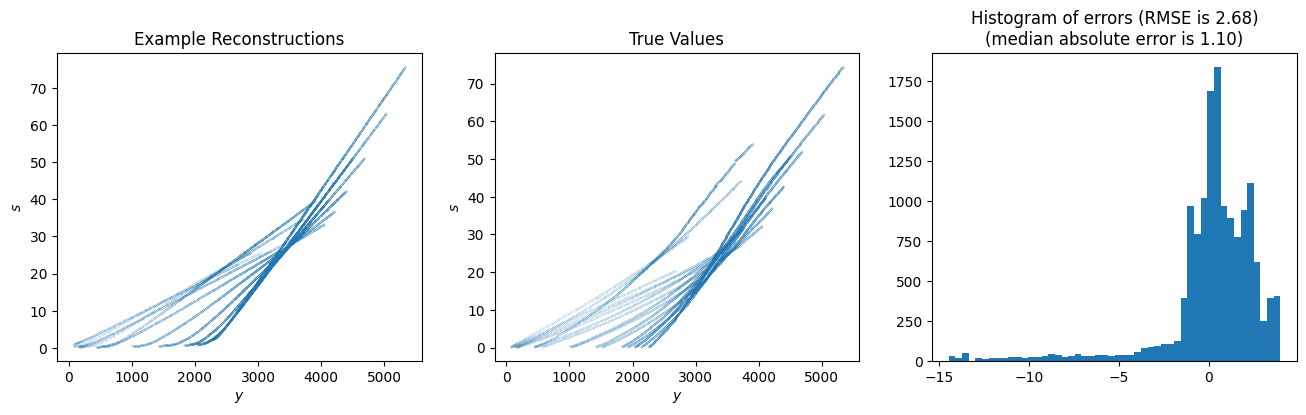

Experimental data (with ring train set):


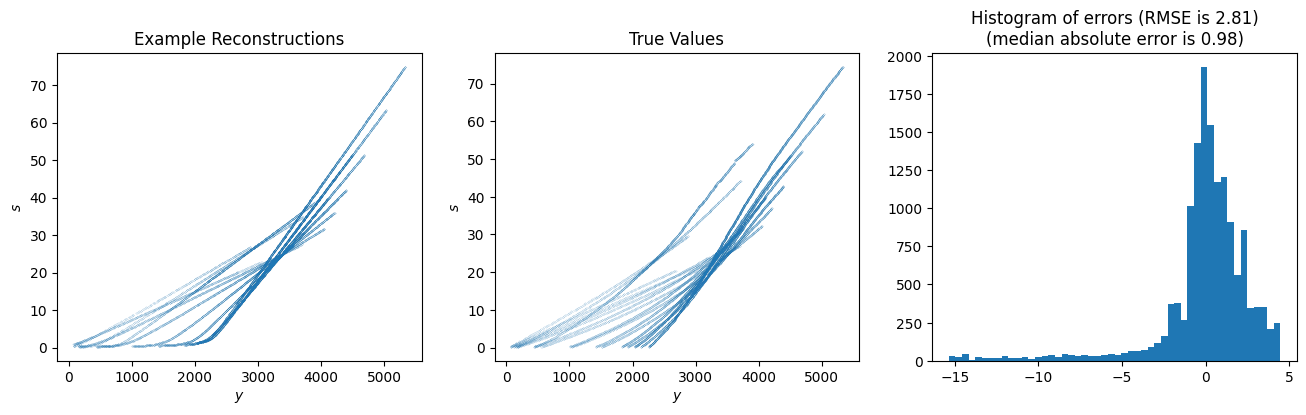

Curve-fit data:


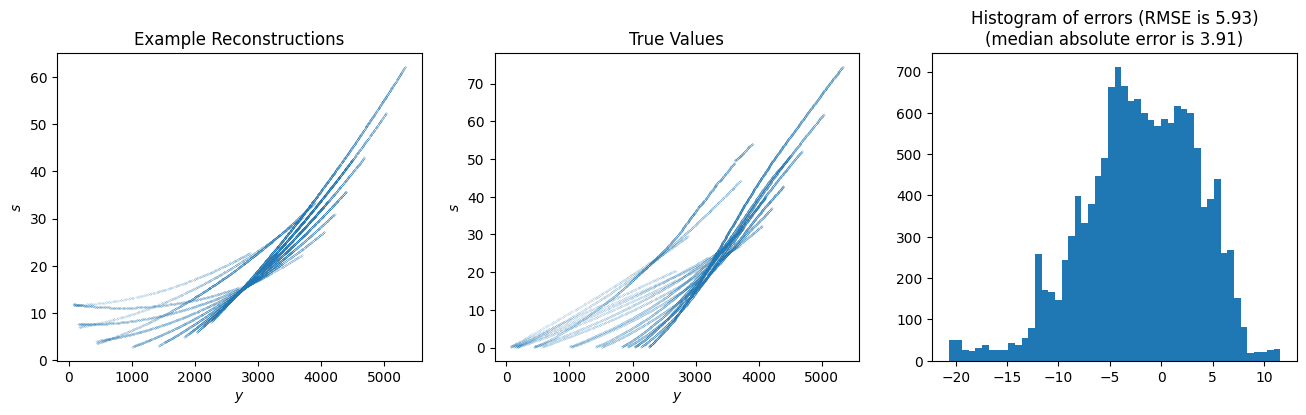

After fold # 1 with nIter=4000:
Experimental NN RMSE: 2.7 [N]
Ring_Included Experimental RMSE: 2.8 [N]
Curve-fit RMSE: 5.9 [N]
----------------------------------------
Running for test group 2...


100%|██████████| 4000/4000 [09:00<00:00,  7.41it/s, loss=1.0953715, grad_norm=0.63988745]


Experimental data:


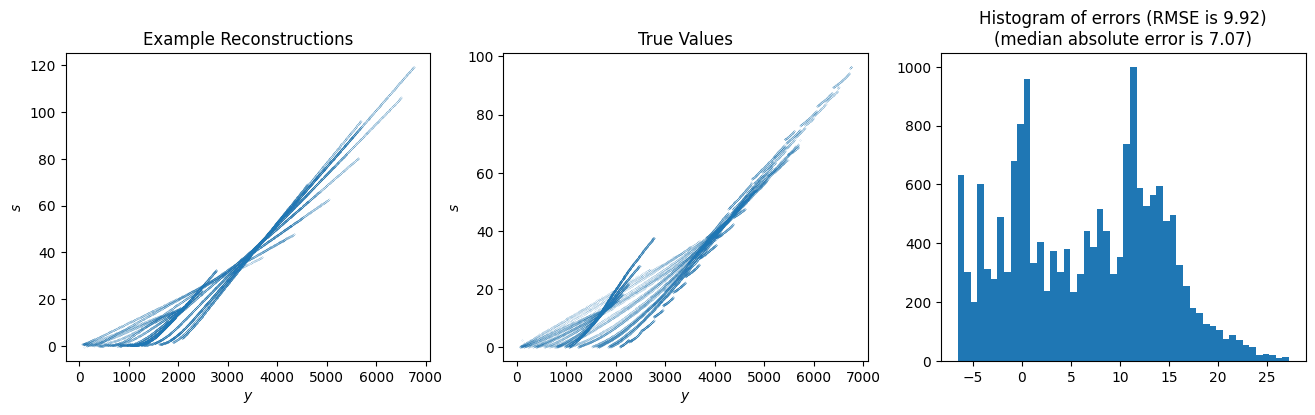

Experimental data (with ring train set):


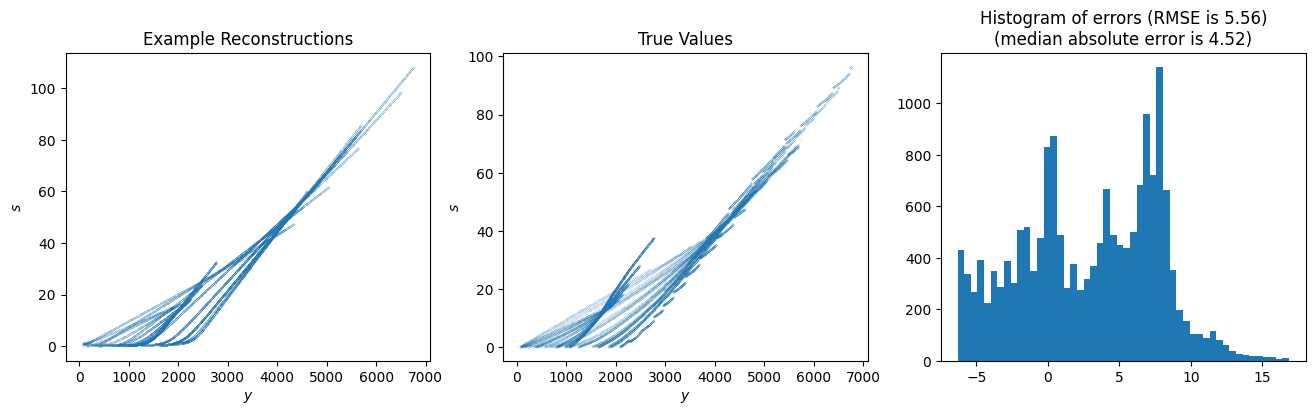

Curve-fit data:


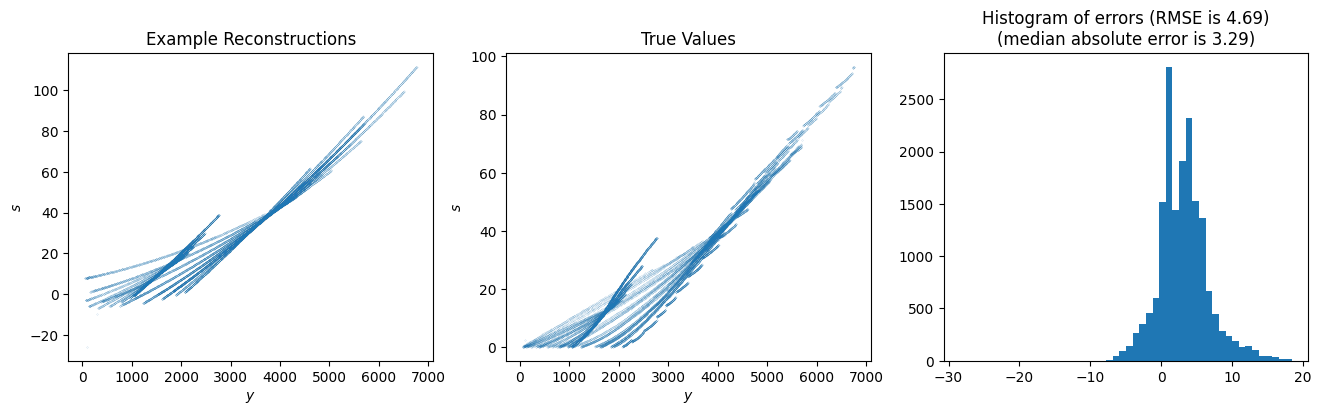

After fold # 2 with nIter=4000:
Experimental NN RMSE: 9.9 [N]
Ring_Included Experimental RMSE: 5.6 [N]
Curve-fit RMSE: 4.7 [N]
----------------------------------------
Running for test group 3...


100%|██████████| 4000/4000 [08:58<00:00,  7.43it/s, loss=1.0711823, grad_norm=0.77066624]


Experimental data:


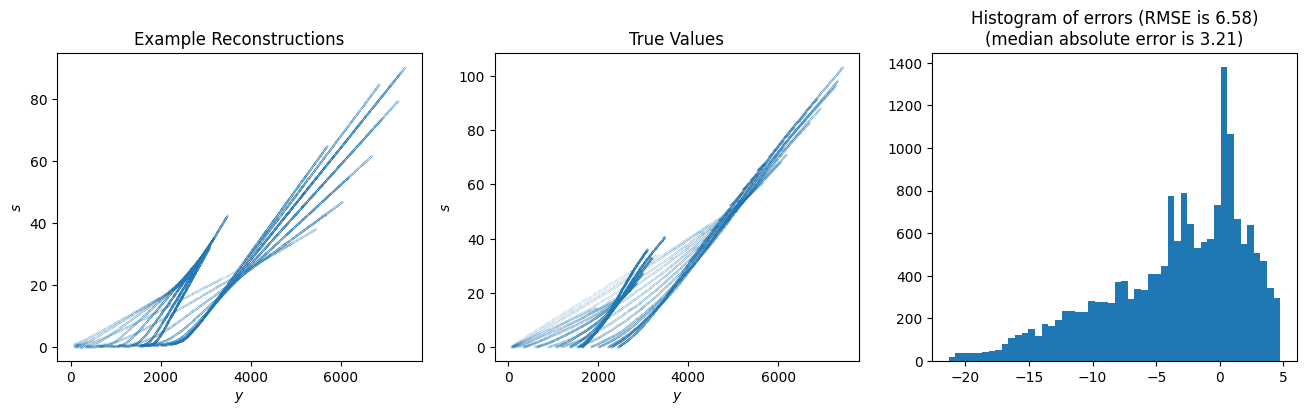

Experimental data (with ring train set):


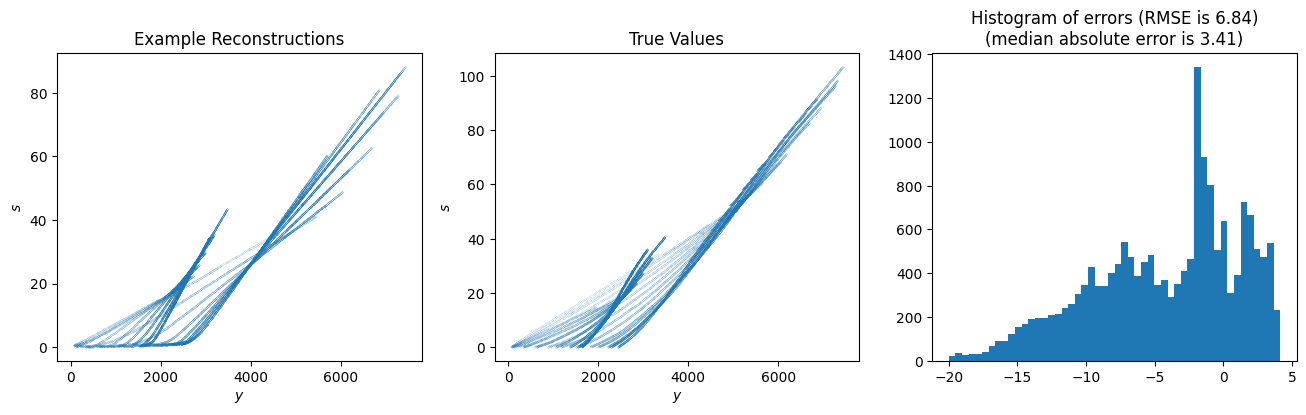

Curve-fit data:


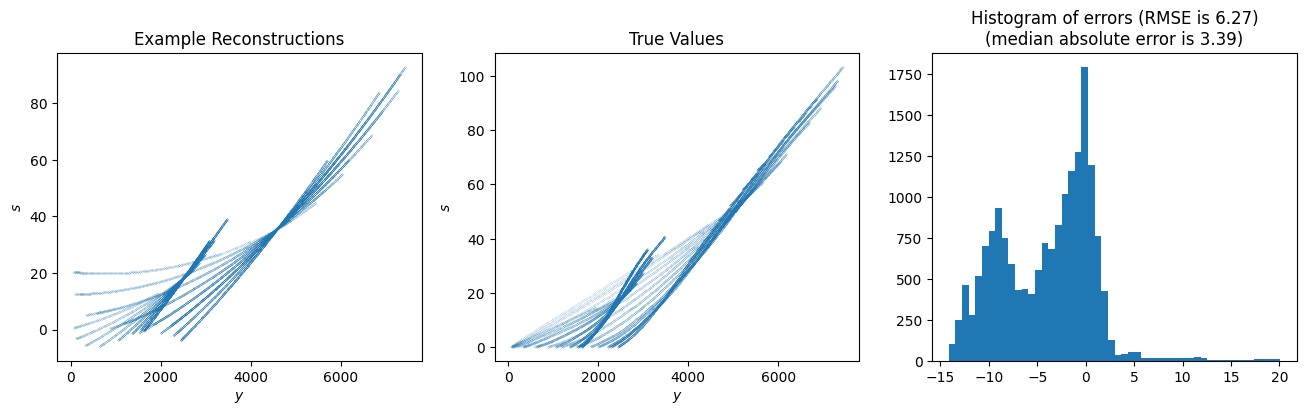

After fold # 3 with nIter=4000:
Experimental NN RMSE: 6.6 [N]
Ring_Included Experimental RMSE: 6.8 [N]
Curve-fit RMSE: 6.3 [N]
----------------------------------------
Average RMSEs over 3 folds with nIter=4000:
Experimental NN RMSE: 6.4 [N]
Ring_Included Experimental RMSE: 5.1 [N]
Curve-fit RMSE: 5.6 [N]


In [23]:
# Main loop for k-fold cross validation

# define k groups
k = 3 # how many groups will the membranes be split into
seed = 8 # seed for k-fold split
membranes_per_group = len(all_nr_data) // k
k_groups = jnp.split(random.permutation(random.key(seed), jnp.arange(len(all_nr_data))), k)

print(f'K-fold cross-validation for {k} groups with {membranes_per_group} membranes per group')

num_iterations_train = 4_000

exp_RMSEs = []
exp_w_r_RMSEs = []
curve_fit_RMSEs = []

# iterate through (to test, choose) k group
for test_k in range(k):
    print(f'Running for test group {test_k+1}...')

    # choose data
    test_data, test_group_mems = choose_exp_test_data(test_k, k_groups, all_data)
    w_r_train_data = choose_exp_all_train_data(test_k, k_groups, all_data)
    train_data = choose_exp_train_data(test_k, k_groups, all_nr_data)
    sk_train = sk_train_data(test_k, k_groups, sk_nr_data)
    sk_test = sk_test_data(test_k, k_groups, sk_nr_data)

    data_loader = BatchedDataset(train_data, key=random.PRNGKey(58), batch_size=1_000, has_weights=True)
    w_r_data_loader = BatchedDataset(w_r_train_data, key=random.PRNGKey(58), batch_size=1_000, has_weights=True)

    # initialize models (3x MLP)
    exp_model = init_model(train_data, data_loader)

    w_r_exp_model = init_model(w_r_train_data, w_r_data_loader)

    # train models
    exp_model.train(data_loader, nIter=num_iterations_train)
    w_r_exp_model.train(w_r_data_loader, nIter=num_iterations_train)
    curve_fit_train_out = poly_train_pred(sk_train, sk_train)

    # predict on test data, plot.
    print('Experimental data:')
    exp_RMSE = exp_model.plot_predictions(test_data, return_RMSE=True)
    print('Experimental data (with ring train set):')
    exp_w_r_RMSE = w_r_exp_model.plot_predictions(test_data, return_RMSE=True)
    print('Curve-fit data:')
    curve_fit_test_out = poly_train_pred(sk_train, sk_test)
    curve_fit_RMSE = plot_sk(sk_test, curve_fit_test_out, return_RMSE=True)

    # append RMSEs to list
    exp_RMSEs.append(exp_RMSE)
    exp_w_r_RMSEs.append(exp_w_r_RMSE)
    curve_fit_RMSEs.append(curve_fit_RMSE)

    # compare RMSE
    print(f'After fold # {test_k+1} with nIter={num_iterations_train}:')
    print(f'Experimental NN RMSE: {exp_RMSE:.1f} [N]')
    print(f'Ring_Included Experimental RMSE: {exp_w_r_RMSE:.1f} [N]')
    print(f'Curve-fit RMSE: {curve_fit_RMSE:.1f} [N]')
    print('----------------------------------------')


# print average RMSEs
print(f'Average RMSEs over {k} folds with nIter={num_iterations_train}:')
print(f'Experimental NN RMSE: {jnp.mean(jnp.array(exp_RMSEs)):.1f} [N]')
print(f'Ring_Included Experimental RMSE: {jnp.mean(jnp.array(exp_w_r_RMSEs)):.1f} [N]')
print(f'Curve-fit RMSE: {jnp.mean(jnp.array(curve_fit_RMSEs)):.1f} [N]')


In [24]:
print(f'Experimental NN RMSE: {jnp.mean(jnp.array(exp_RMSEs)):.1f} [N]')
print(f'Ring_Included Experimental RMSE: {jnp.mean(jnp.array(exp_w_r_RMSEs)):.1f} [N]')
print(f'Curve-fit RMSE: {jnp.mean(jnp.array(curve_fit_RMSEs)):.1f} [N]')

Experimental NN RMSE: 6.4 [N]
Ring_Included Experimental RMSE: 5.1 [N]
Curve-fit RMSE: 5.6 [N]


In [25]:
test_data, test_group_mems = choose_exp_test_data(test_k, k_groups, all_data)
train_data = choose_exp_train_data(test_k, k_groups, all_nr_data)

# solve max value of force between test & train data
max_force1 = jnp.max(test_data[1])
max_force2 = jnp.max(train_data[1])
print(f'Max force seen: {jnp.max(jnp.array([max_force1, max_force2])):.1f} [N]')
print(f'Curve-Fit Percent Error: {100*(jnp.mean(jnp.array(curve_fit_RMSEs))/jnp.max(jnp.array([max_force1, max_force2]))):.2f}%')

Max force seen: 103.3 [N]
Curve-Fit Percent Error: 5.45%


K-fold cross-validation for 8 groups with 2 membranes per group
Running for test group 1...


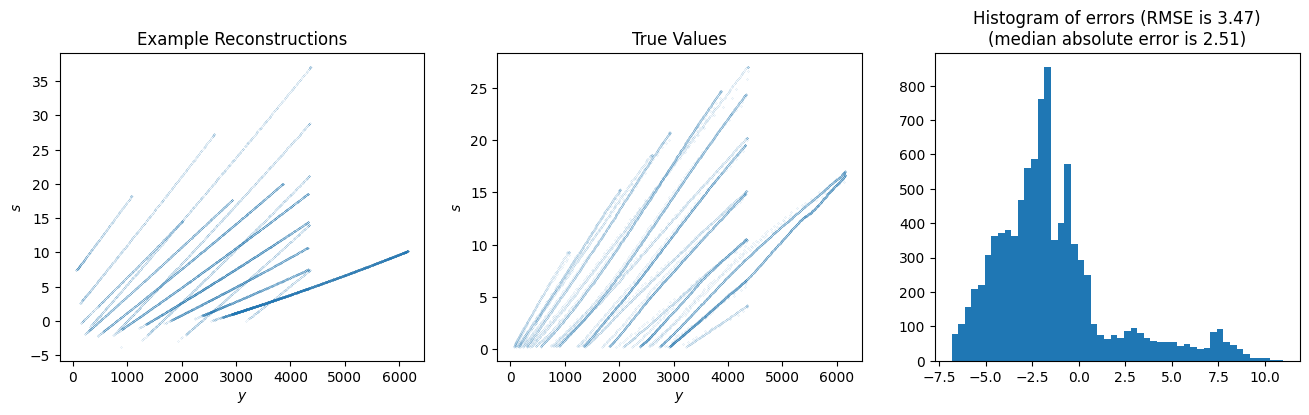

After fold # 1:
Curve-fit RMSE: 3.5 [N]
----------------------------------------
Running for test group 2...


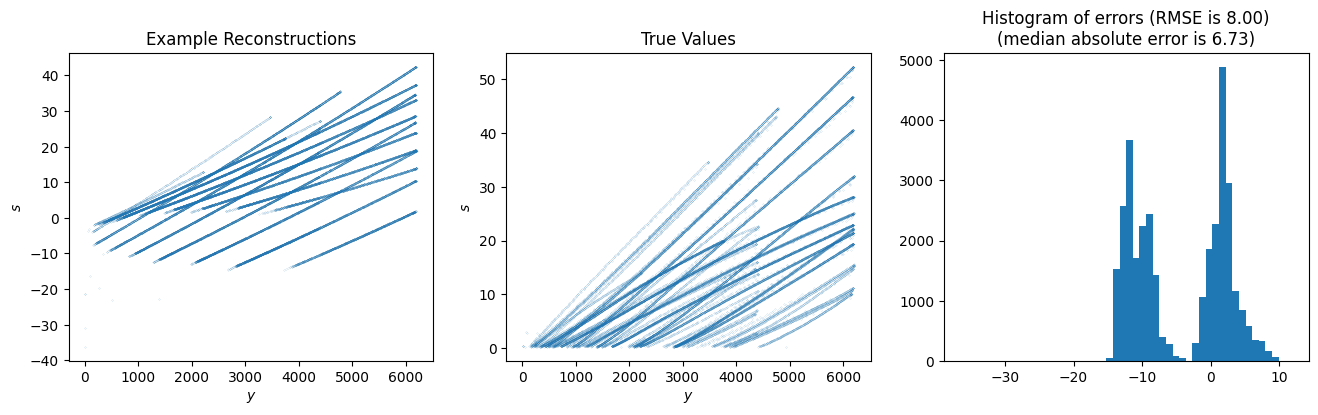

After fold # 2:
Curve-fit RMSE: 8.0 [N]
----------------------------------------
Running for test group 3...


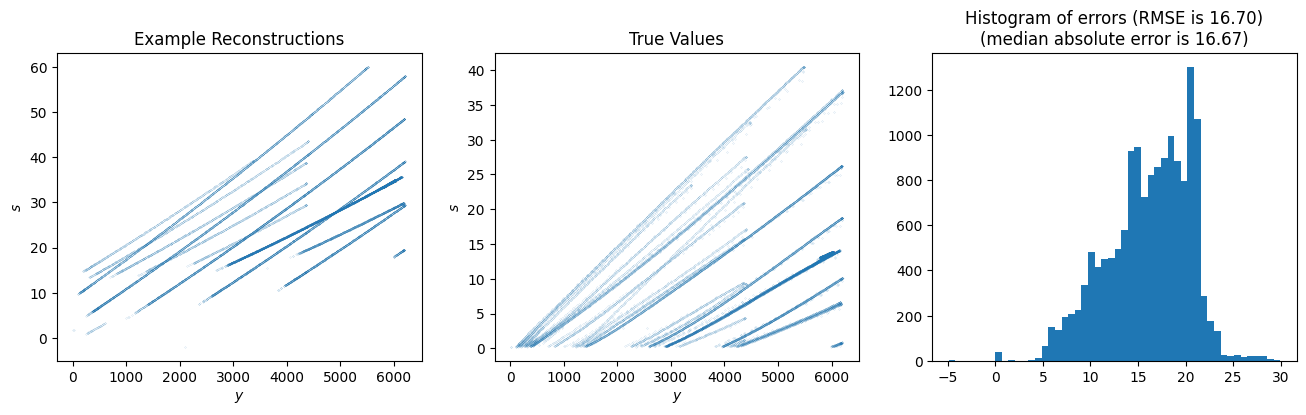

After fold # 3:
Curve-fit RMSE: 16.7 [N]
----------------------------------------
Running for test group 4...


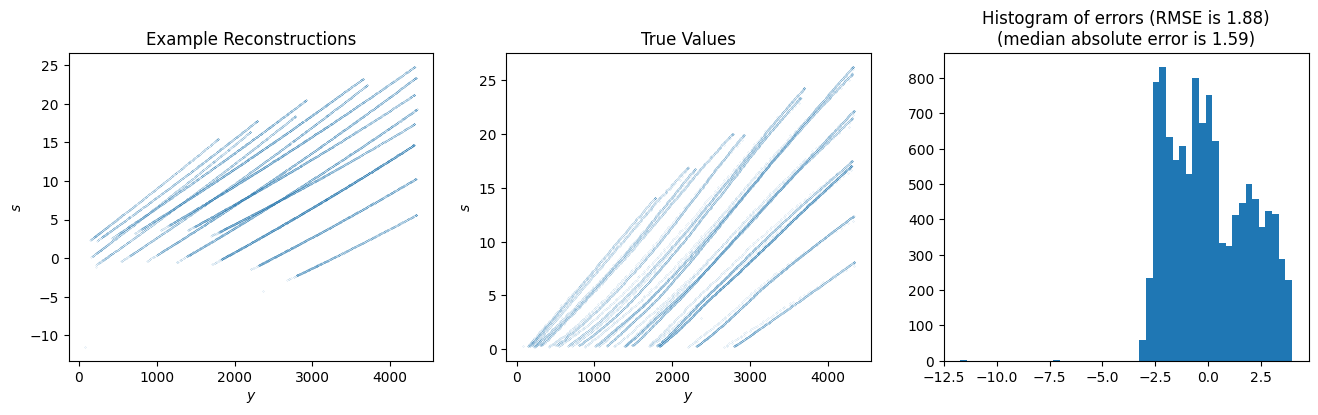

After fold # 4:
Curve-fit RMSE: 1.9 [N]
----------------------------------------
Running for test group 5...


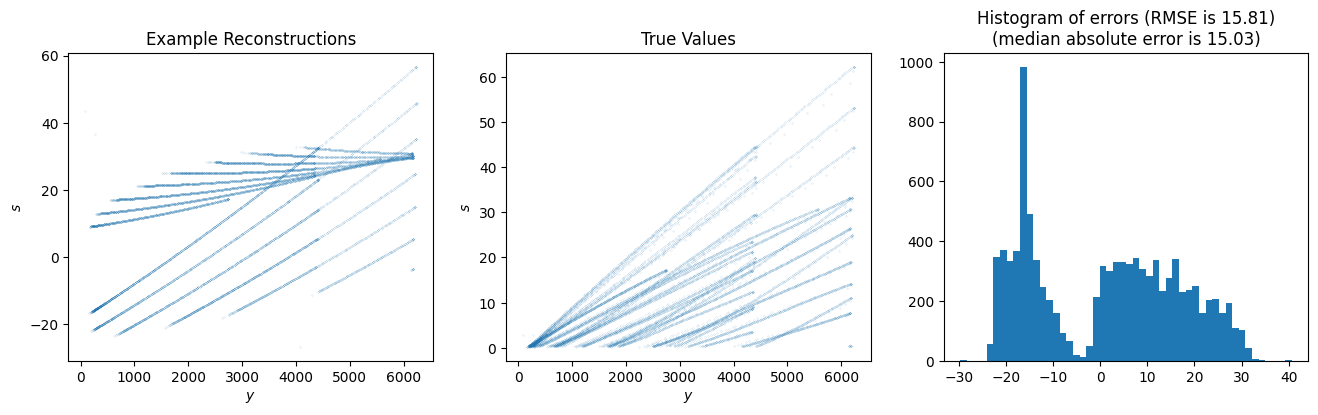

After fold # 5:
Curve-fit RMSE: 15.8 [N]
----------------------------------------
Running for test group 6...


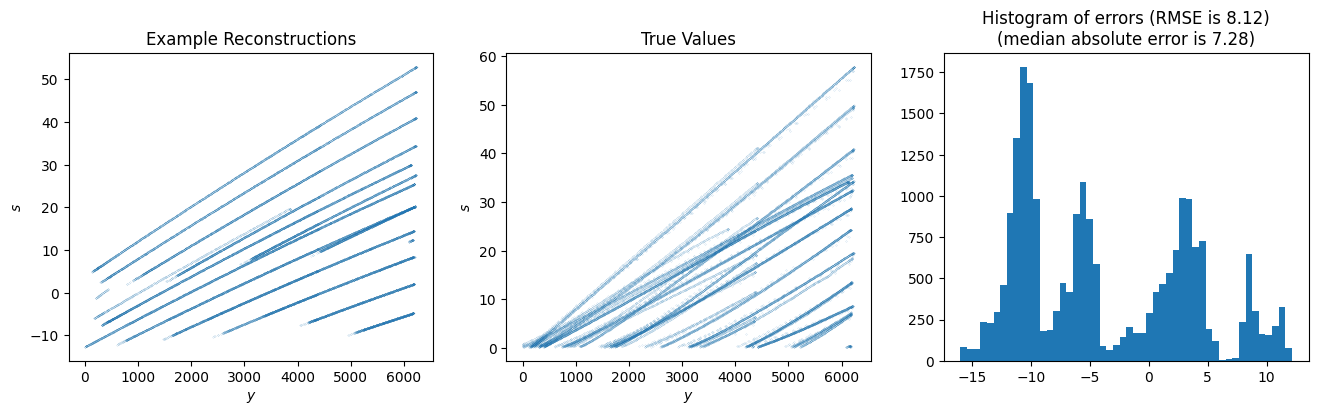

After fold # 6:
Curve-fit RMSE: 8.1 [N]
----------------------------------------
Running for test group 7...


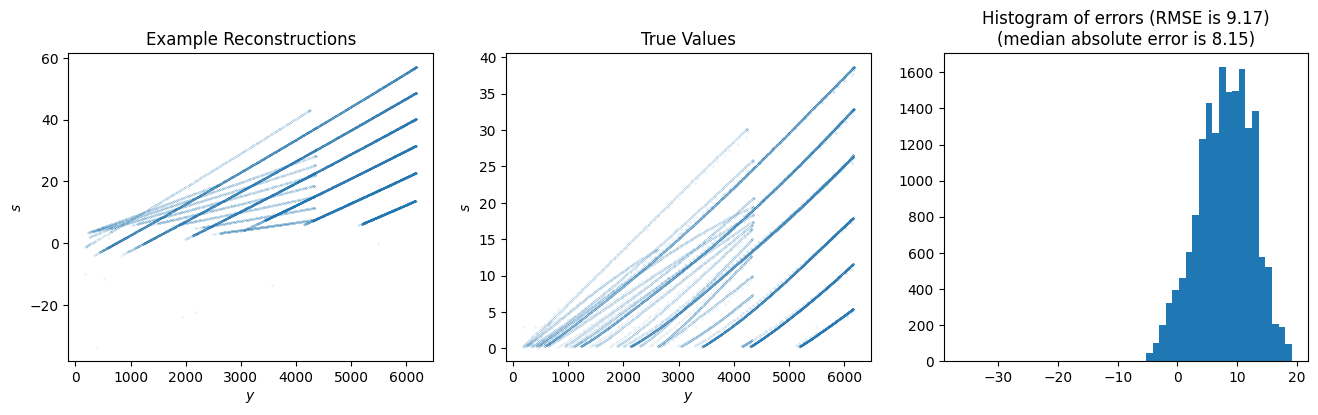

After fold # 7:
Curve-fit RMSE: 9.2 [N]
----------------------------------------
Running for test group 8...


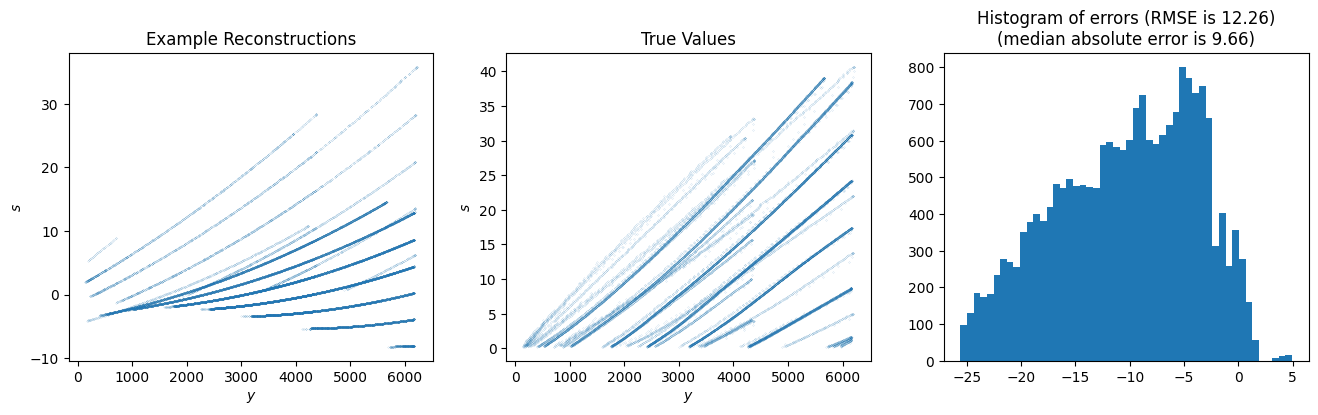

After fold # 8:
Curve-fit RMSE: 12.3 [N]
----------------------------------------
Average RMSEs over 8 folds:
Curve-fit RMSE: 9.4 [N]


In [26]:
# Main loop for k-fold cross validation

# define k groups
k = 8 # how many groups will the membranes be split into
seed = 8 # seed for k-fold split
membranes_per_group = len(sk_ring_data) // k
k_groups = jnp.split(random.permutation(random.key(seed), jnp.arange(len(sk_ring_data))), k)

print(f'K-fold cross-validation for {k} groups with {membranes_per_group} membranes per group')

curve_fit_ringed_RMSEs = []

# iterate through (to test, choose) k group
for test_k in range(k):
    print(f'Running for test group {test_k+1}...')

    # choose data
    sk_train = sk_train_data(test_k, k_groups, sk_ring_data)
    sk_test = sk_test_data(test_k, k_groups, sk_ring_data)

    curve_fit_train_out = poly_train_pred(sk_train, sk_train)

    curve_fit_test_out = poly_train_pred(sk_train, sk_test)
    curve_fit_RMSE = plot_sk(sk_test, curve_fit_test_out, return_RMSE=True)

    # append RMSEs to list
    curve_fit_ringed_RMSEs.append(curve_fit_RMSE)

    # compare RMSE
    print(f'After fold # {test_k+1}:')
    print(f'Curve-fit RMSE: {curve_fit_RMSE:.1f} [N]')
    print('----------------------------------------')


# print average RMSEs
print(f'Average RMSEs over {k} folds:')
print(f'Curve-fit RMSE: {jnp.mean(jnp.array(curve_fit_ringed_RMSEs)):.1f} [N]')
